## LIN350 Course Project - The Language of Immigration Politics: Terminology Differences Across Party Lines in Congressional Speeches

The way I usually run jupyter notebooks is opening the anaconda prompt terminal and running the command *jupyter notebook* from there I go to visual studio and click on select kernel -> existing jupyter server -> localhost or you can copy and paste the url of the tab that opened up with the *jupyter notebook* command and then click on python and that should be it

To keep track of the work we're doing together we can use a github repository to update changes and sync up our work. The usual workflow for this should be.
1. Any changes you have in your laptop can be added to the repository with "git add ./" from the terminal the notebook is in
2. After adding the files and changes you can use "git commit -m 'message here'" For the message make sure its in quotations and it can be anything
3. After adding and commiting you can "git push" which pushes ur changes to the repository
4. Let's say there's changes in the repository that are not in your laptop you can fetch them with "git pull"

Some other setup you might need to do is set environement variables in local computer since we don't want to share that in the repository for privacy issues. So to do this you would run commands in your notebook to set it up. I'll show you
1. running "%env" in a code block will show you all the environment variables in the jupyter environment
2. to set up the enviroment variable for our project run the command "%env API_KEY=apikeyfromourgoogledocs"
3. After that running the first cell of code will setup the api key to be used as API_KEY


### Congressional Record Data Collector - Very simple for now, simple text data collection

In [4]:
%env API_KEY=qAyZUrTJs4fdKIPefgekdiMQrCchdt979fIo58M1

env: API_KEY=qAyZUrTJs4fdKIPefgekdiMQrCchdt979fIo58M1


In [ ]:
%pip install Xlsxwriter

#### SECTION 1: INTRODUCTION AND SETUP


In [36]:


"""

Research Questions:

1. What statistically significant differences exist in the frequency of 
immigration-related terminology (e.g., “undocumented” vs. “illegal”) between 
Democratic and Republican representatives?**

2. How has party-specific immigration terminology shifted during key political 
events between 2017 and 2021, such as the DACA debates, the 2018–2019 government
shutdown, or early Biden-era policy reversals?

3. What contextual linguistic patterns (e.g., collocates, frames, sentiment) 
surround immigration terms in each party's discourse, and how do these reflect 
broader ideological narratives or legislative priorities?

The project analyzes Congressional Record speeches to investigate how politicians from
different parties use immigration-related terminology, following the methodologies
covered in the LIN350 course.
"""

import requests
import json
import os
import pandas as pd
import time
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import glob
import re
from bs4 import BeautifulSoup
import xlsxwriter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import nltk
nltk.download('punkt') 
from nltk.tokenize import word_tokenize, sent_tokenize
from scipy.stats import chi2_contingency
from wordcloud import WordCloud



def setup_directories():
    # create all necessary directories for the project. returns a dictionary of important paths.
    base_dir = os.path.join(os.getcwd())
    
    # main data directories
    data_dir = os.path.join(base_dir, "data")
    raw_data_dir = os.path.join(data_dir, "congressional_record")
    processed_dir = os.path.join(base_dir, "processed_data")
    samples_dir = os.path.join(processed_dir, "speech_samples")
    figures_dir = os.path.join(processed_dir, "figures")  
    
    # create all directories
    for directory in [data_dir, raw_data_dir, processed_dir, samples_dir, figures_dir]:
        os.makedirs(directory, exist_ok=True)
    
    # return dictionary of paths for easy reference
    return {
        "base_dir": base_dir,
        "data_dir": data_dir,
        "raw_data_dir": raw_data_dir,
        "processed_dir": processed_dir,
        "samples_dir": samples_dir,
        "figures_dir": figures_dir
    }

def setup_api_key():
    # set up the API key for accessing the Congress.gov API. returns the API key.

    # uncomment and run this line to set the API key in the notebook environment
    # %env API_KEY=your_api_key_here
    
    try:
        API_KEY = os.environ.get("API_KEY")
        if not API_KEY:
            print("Warning: API_KEY environment variable not found.")
            print("Please run '%env API_KEY=your_api_key' in a cell.")
            return None
        return API_KEY
    except Exception as e:
        print(f"Error accessing API key: {e}")
        return None

# define constants for data collection
def define_constants():   
    date_ranges = [
        # 2019 - Border wall government shutdown
        ("2019-01-01", "2019-01-31"),
        
        # Government shutdown over border wall funding
        ("2018-12-15", "2018-12-31"),

        # DACA debates
        ("2017-09-01", "2017-10-15"),
        ("2018-01-15", "2018-02-15"),
        
        # Border surge discussions
        ("2019-03-01", "2019-04-15"),
        
        # Election year immigration discussions
        ("2020-01-15", "2020-02-15"),
        ("2020-09-01", "2020-10-15"),
        
        # Biden administration policy changes
        ("2021-01-20", "2021-03-01")
    ]
    
    # immigration-related term pairs for analysis
    term_pairs = [
        ("undocumented", "illegal", "unauthorized"),  # Status descriptors
        ("asylum seeker", "refugee", "migrant"),      # Migration categories
        ("border security", "border crisis", "border management"),  # Border framing
        ("path to citizenship", "amnesty"),           # Legal status solutions
        ("dreamers", "daca recipients"),              # Youth beneficiaries 
        ("family separation", "child detention"),      # Child policy framing
        ("chain migration", "family reunification"),  # Family immigration framing
        ("alien", "foreign national", "noncitizen", "undocumented"),  # Legal designation terms
        ("deportation", "removal"),                   # Enforcement terminology
        ("sanctuary cities", "non-cooperative jurisdictions"),  # Local policy framing
        ("border wall", "border barrier", "border infrastructure")  # Border infrastructure
    ]
    
    # immigration-related terms with more precise matching
    immigration_terms = {
        # regular terms - can appear within other words
        'immigration': r'immigration',
        'immigrant': r'immigrant',
        'migrant': r'migrant',
        'citizenship': r'citizenship',
        'deportation': r'deportation',
        
        # terms that need word boundary checks
        'border': r'\b(?:border|borders)\b',
        'asylum': r'\basylum\b',
        'refugee': r'\b(?:refugee|refugees)\b',
        'undocumented': r'\bundocumented\b',
        'illegal alien': r'\billegal\s+alien',
        'unauthorized': r'\bunauthorized\b',
        'wall': r'\bwall\b',
        'daca': r'\bdaca\b',
        'dreamer': r'\b(?:dreamer|dreamers)\b',
        'visa': r'\bvisa\b',
        'detention': r'\bdetention\b',
        
        # phrases
        'family separation': r'family\s+separation',
        'child detention': r'child\s+detention',
        'border security': r'border\s+security',
        'border crisis': r'border\s+crisis',
        'path to citizenship': r'path\s+to\s+citizenship',
        'amnesty': r'\bamnesty\b',
        'caravan': r'\bcaravan\b',
        
        # specific entities
        'mexico': r'\bmexico\b',
        'ice': r'\b(?:ice|immigration and customs enforcement)\b',  # Only match whole word "ice"
        'cbp': r'\b(?:cbp|customs and border protection)\b'
    }

    return {
        "date_ranges": date_ranges,
        "term_pairs": term_pairs,
        "immigration_terms": immigration_terms,
    }

# initialize the project
def initialize_project():
   
    print("Initializing project...\n")
    
    directories = setup_directories()
    print(f"Directory structure created:")
    for name, path in directories.items():
        print(f"  - {name}: {path}")
    
    api_key = setup_api_key()
    if api_key:
        print(f"API key configured")
    
    constants = define_constants()
    print(f"Constants defined:")
    print(f"  - Date ranges: {len(constants['date_ranges'])} periods")
    print(f"  - Term pairs: {len(constants['term_pairs'])} pairs/groups")
    print(f"  - Immigration terms: {len(constants['immigration_terms'])} terms")
    
    config = {
        "directories": directories,
        "api_key": api_key,
        "constants": constants
    }
    
    print("\nProject initialization complete!")
    return config

# run initialization
config = initialize_project()


Initializing project...

Directory structure created:
  - base_dir: c:\Users\Kevin\Downloads\LIN350Project
  - data_dir: c:\Users\Kevin\Downloads\LIN350Project\data
  - raw_data_dir: c:\Users\Kevin\Downloads\LIN350Project\data\congressional_record
  - processed_dir: c:\Users\Kevin\Downloads\LIN350Project\processed_data
  - samples_dir: c:\Users\Kevin\Downloads\LIN350Project\processed_data\speech_samples
  - figures_dir: c:\Users\Kevin\Downloads\LIN350Project\processed_data\figures
Please run '%env API_KEY=your_api_key' in a cell.
Constants defined:
  - Date ranges: 8 periods
  - Term pairs: 11 pairs/groups
  - Immigration terms: 26 terms

Project initialization complete!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### SECTION 2: DATA COLLECTION


In [8]:

# function to generate all dates in a given range
def get_dates_in_range(start_date, end_date):
    # start_date (str): Start date in format 'YYYY-MM-DD'
    # end_date (str): End date in format 'YYYY-MM-DD'
        
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    date_list = []
    current = start
    while current <= end:
        date_list.append(current.strftime("%Y-%m-%d"))
        current += timedelta(days=1)
    return date_list

def verify_api_key(api_key):

    test_url = "https://api.govinfo.gov/collections"
    params = {
        'api_key': api_key
    }

    try:
        print("Testing API key with GovInfo API...")
        response = requests.get(test_url, params=params)
        
        if response.status_code == 200:
            print("Success! Your API key is valid for the GovInfo API.")
            print(f"Status code: {response.status_code}")
            
            # show the first few collections to confirm we got real data
            collections = response.json().get('collections', [])
            if collections:
                print("\nAvailable collections:")
                for collection in collections[:5]:
                    print(f"- {collection.get('collectionName', 'Unknown')}")
            return True
            
        elif response.status_code == 401 or response.status_code == 403:
            print("Authentication failed. Your API key appears to be invalid.")
            print(f"Status code: {response.status_code}")
            print(f"Response: {response.text}")
            return False
        else:
            print(f"Received unexpected status code: {response.status_code}")
            print(f"Response: {response.text}")
            return False
            
    except Exception as e:
        print(f"Error occurred while testing the API key: {e}")
        return False

# function to get Congressional Record data using the GovInfo API
def get_congressional_record(date, api_key, raw_data_dir):
    """
    Args:
        date (str): Date in format 'YYYY-MM-DD'
        api_key (str): API key for the GovInfo API
        raw_data_dir (str): Directory to save raw data  
    """
    package_id = f"CREC-{date}"
    package_url = f"https://api.govinfo.gov/packages/{package_id}/summary"
    params = {
        'api_key': api_key
    }
    try:
        # check if the package exists
        response = requests.get(package_url, params=params)
    
        # if package doesn't exist or other error
        if response.status_code != 200:
            print(f"No Congressional Record available for {date} (Status: {response.status_code})")
            return False
        
        # save the package summary
        with open(os.path.join(raw_data_dir, f"{package_id}-summary.json"), 'w') as f:
            json.dump(response.json(), f)
        
        # get granules (speeches and entries) 
        granules_url = f"https://api.govinfo.gov/packages/{package_id}/granules"
        granules_params = {
            'api_key': api_key,
            'offset': 0,
            'pageSize': 100  # Max page size
        }
        
        # get first page of granules
        granules_response = requests.get(granules_url, params=granules_params)
        
        if granules_response.status_code != 200:
            print(f"Failed to get granules for {date} (Status: {granules_response.status_code})")
            return False
            
        # save the granules list
        with open(os.path.join(raw_data_dir, f"{package_id}-granules.json"), 'w') as f:
            json.dump(granules_response.json(), f)
            
        # download content for each granule
        granules = granules_response.json().get('granules', [])
        
        for granule in granules:
            granule_id = granule.get('granuleId')
            
            # skip if no granule ID
            if not granule_id:
                continue
            
            # get the HTML content
            content_url = f"https://api.govinfo.gov/packages/{package_id}/granules/{granule_id}/htm"
            content_response = requests.get(content_url, params=params)
            
            if content_response.status_code == 200:
                # save the HTML content
                with open(os.path.join(raw_data_dir, f"{package_id}-{granule_id}.html"), 'w', encoding='utf-8') as f:
                    f.write(content_response.text)
            
            # respect rate limit
            time.sleep(0.5)
            
        print(f"Successfully downloaded Congressional Record for {date} ({len(granules)} granules)")
        return True
        
    except Exception as e:
        print(f"Error retrieving data for {date}: {e}")
        return False

# main function to download Congressional Record data
def collect_congressional_data(config):
    """
    Args: config (dict): Project configuration
    Returns: int: Number of successfully downloaded dates
    """
    api_key = config["api_key"]
    date_ranges = config["constants"]["date_ranges"]
    raw_data_dir = config["directories"]["raw_data_dir"]
    
    if not verify_api_key(api_key):
        print("Cannot proceed with data collection due to invalid API key.")
        return 0
    
    all_dates = []
    
    # generate all dates in the specified ranges
    for start_date, end_date in date_ranges:
        dates = get_dates_in_range(start_date, end_date)
        all_dates.extend(dates)
    
    print(f"Will download Congressional Record data for {len(all_dates)} dates")
    
    # download data for each date, commented out because I we already collected the data
    successful_downloads = 0
    # for date in tqdm(all_dates, desc="Downloading Congressional Records"):
    #     success = get_congressional_record(date, api_key, raw_data_dir)
    #     if success:
    #         successful_downloads += 1
        
    #     # Wait between requests to avoid rate limiting
    #     time.sleep(1)
    
    print(f"\nData collection complete!")
    print(f"Successfully downloaded data for {successful_downloads} out of {len(all_dates)} dates")
    print(f"Data saved to: {raw_data_dir}")
    
    return successful_downloads

# Uncomment to run data collection
successful_downloads = collect_congressional_data(config)


Testing API key with GovInfo API...
Success! Your API key is valid for the GovInfo API.
Status code: 200

Available collections:
- Congressional Bills
- Congressional Bill Status
- Congressional Bill Summaries
- United States Budget
- Congressional Calendars
Will download Congressional Record data for 289 dates

Data collection complete!
Successfully downloaded data for 0 out of 289 dates
Data saved to: c:\Users\Kevin\Downloads\LIN350Project\data\congressional_record


In [9]:
# build a df of legislators from the @unitedstates Github data (2017-2022)
current_file = "data\\legislator_data\\unitedstates.github.io\\legislators-current.json"
historical_file = "data\\legislator_data\\unitedstates.github.io\\legislators-historical.json"
def build_legislators_dataframe(current_file=current_file, 
                               historical_file=historical_file):
   
    with open(current_file, 'r') as f:
        current = json.load(f)
    
    with open(historical_file, 'r') as f:
        historical = json.load(f)
    
    all_legislators = current + historical
    legislator_records = []
    
    study_start = datetime.strptime('2017-01-01', '%Y-%m-%d')
    study_end = datetime.strptime('2022-12-31', '%Y-%m-%d')
    
    for legislator in all_legislators:
        # legislator info
        legislator_id = legislator.get('id', {}).get('bioguide', '')
        first_name = legislator.get('name', {}).get('first', '')
        last_name = legislator.get('name', {}).get('last', '')
        
        # process each term to see if any fall within our study period
        for term in legislator.get('terms', []):
            term_start = datetime.strptime(term.get('start', '1900-01-01'), '%Y-%m-%d')
            term_end = datetime.strptime(term.get('end', '2100-01-01'), '%Y-%m-%d')
            
            # check if this term overlaps with our study period
            if (term_start <= study_end and term_end >= study_start):
                record = {
                    'bioguide_id': legislator_id,
                    'first_name': first_name,
                    'last_name': last_name,
                    'last_name_upper': last_name.upper(),  # For easier matching
                    'full_name': legislator.get('name', {}).get('official_full', f"{first_name} {last_name}"),
                    'state': term.get('state', ''),
                    'party': term.get('party', ''),
                    'type': term.get('type', ''),  # 'sen' or 'rep'
                    'term_start': term.get('start', ''),
                    'term_end': term.get('end', ''),
                    'state_rank': term.get('state_rank', '')  # 'junior' or 'senior' for senators
                }
                legislator_records.append(record)
    
    df = pd.DataFrame(legislator_records)
    df.to_csv('legislators_2017_2022.csv', index=False)
    print(f"Created DataFrame with {len(df)} records from {len(set(df['bioguide_id']))} unique legislators")
    
    return df

legislators_df = build_legislators_dataframe()

Created DataFrame with 2010 records from 796 unique legislators


In [10]:
# extract speaker information and determine party from Congressional Record text
# returns party and details about how the match was made
def get_party_from_speech(speech_text, legislators_df):
    # regex
    speaker_match = re.search(r'(?:Mr\.|Mrs\.|Ms\.|Representative|Senator)\s+([A-Z][A-Za-z\'\-]+)(?:\s+of\s+([A-Za-z\s]+))?', speech_text)
    
    if not speaker_match:
        return None, "No speaker pattern found"
    
    last_name = speaker_match.group(1)
    state_name = speaker_match.group(2)
    
    matches = legislators_df[legislators_df['last_name_upper'] == last_name]
    
    if len(matches) == 0:
        with open("unmatched_speakers.txt", "a") as log_file:
            log_file.write(f"{last_name} | From: {speech_text[:200]}...\n")
        return None, f"No match found for {last_name}"

    
    if len(matches) == 1:
        # single match - straightforward case
        return matches.iloc[0]['party'], "Unique last name match"
    
    # multiple matches - try to narrow down with state
    if state_name:
        # convert full state name to abbreviation
        state_abbrev = state_name_to_abbrev(state_name)
        state_matches = matches[matches['state'] == state_abbrev]
        
        if len(state_matches) == 1:
            return state_matches.iloc[0]['party'], f"Resolved with state ({state_abbrev})"
        elif len(state_matches) > 1:
            # still multiple matches with same state
            # sort by term_end to get the most recent/current legislator
            recent_match = state_matches.sort_values('term_end', ascending=False).iloc[0]
            return recent_match['party'], f"Multiple matches with state, using most recent ({recent_match['full_name']})"
    
    # no state or state didn't narrow it down - use most recent term
    recent_match = matches.sort_values('term_end', ascending=False).iloc[0]
    return recent_match['party'], f"Multiple matches, using most recent ({recent_match['full_name']})"

# helper function to get state name to abbrev
def state_name_to_abbrev(state_name):
    state_name = state_name.strip().lower()
    states = {
        'alabama': 'AL', 'alaska': 'AK', 'arizona': 'AZ', 'arkansas': 'AR', 'california': 'CA',
        'colorado': 'CO', 'connecticut': 'CT', 'delaware': 'DE', 'florida': 'FL', 'georgia': 'GA',
        'hawaii': 'HI', 'idaho': 'ID', 'illinois': 'IL', 'indiana': 'IN', 'iowa': 'IA',
        'kansas': 'KS', 'kentucky': 'KY', 'louisiana': 'LA', 'maine': 'ME', 'maryland': 'MD',
        'massachusetts': 'MA', 'michigan': 'MI', 'minnesota': 'MN', 'mississippi': 'MS', 'missouri': 'MO',
        'montana': 'MT', 'nebraska': 'NE', 'nevada': 'NV', 'new hampshire': 'NH', 'new jersey': 'NJ',
        'new mexico': 'NM', 'new york': 'NY', 'north carolina': 'NC', 'north dakota': 'ND', 'ohio': 'OH',
        'oklahoma': 'OK', 'oregon': 'OR', 'pennsylvania': 'PA', 'rhode island': 'RI', 'south carolina': 'SC',
        'south dakota': 'SD', 'tennessee': 'TN', 'texas': 'TX', 'utah': 'UT', 'vermont': 'VT',
        'virginia': 'VA', 'washington': 'WA', 'west virginia': 'WV', 'wisconsin': 'WI', 'wyoming': 'WY'
    }
    
    return states.get(state_name, state_name)

# example usage:
def analyze_speech_by_party(speech_text, legislators_df, term_pairs):
    """
    Analyze usage of immigration term pairs in a speech text
    and attribute them to the speaker's party
    """
    party, match_details = get_party_from_speech(speech_text, legislators_df)
    
    if not party:
        return None, f"Could not determine party: {match_details}"
    
    # init. dictionary to store term counts by party
    term_counts = {term: 0 for pair in term_pairs for term in pair}
    
    # count occurrences of each term in the speech
    for pair in term_pairs:
        for term in pair:
            # count how many times the term appears in the speech (case insensitive)
            count = len(re.findall(r'\b' + re.escape(term) + r'\b', speech_text, re.IGNORECASE))
            term_counts[term] = count
    
    return party, term_counts



#### SECTION 3: DATA PROCESSING


In [11]:

# function to identify immigration-related files
def identify_immigration_files(config):
    """
    searches through all HTML files and identifies those containing immigration-related terms.
    
    Args:
        config (dict): Project configuration
        
    Returns:
        pandas.DataFrame: DataFrame of immigration-related files
    """
    raw_data_dir = config["directories"]["raw_data_dir"]
    processed_dir = config["directories"]["processed_dir"]
    immigration_terms = config["constants"]["immigration_terms"]
    
    # list of all HTML files
    html_files = glob.glob(os.path.join(raw_data_dir, "*.html"))
    total_files = len(html_files)
    
    print(f"Found {total_files} HTML files in {raw_data_dir}")
    
    # check the first few files to make sure we can access them
    if total_files > 0:
        print("\nSample filenames:")
        for file in html_files[:5]:
            print(f"  - {os.path.basename(file)}")
        
        # try to open one file to verify access
        try:
            with open(html_files[0], 'r', encoding='utf-8') as f:
                first_chars = f.read(200)
            print("\nSuccessfully read first file. First 200 characters:")
            print(first_chars.replace('\n', ' ')[:200])
        except Exception as e:
            print(f"\nError reading file: {e}")
    
    # search for immigration-related content
    immigration_files = []
    print(f"Searching {total_files} files for immigration content...")

    for file in tqdm(html_files, desc="Searching files for immigration terms"):
        try:
            with open(file, 'r', encoding='utf-8') as f:
                content = f.read().lower()
                
            # check each term with its specific regex pattern
            found_terms = []
            for term, pattern in immigration_terms.items():
                if re.search(pattern, content):
                    found_terms.append(term)
            
            if found_terms:
                # extract date from filename
                filename = os.path.basename(file)
                date_parts = filename.split('-')
                if len(date_parts) >= 2:
                    date = date_parts[1]
                else:
                    date = "Unknown"
                
                immigration_files.append({
                    'file': file,
                    'date': date,
                    'terms': ', '.join(found_terms)  # convert list to string
                })
        except Exception as e:
            print(f"Error processing {os.path.basename(file)}: {e}")

    # save results to CSV
    if immigration_files:
        immigration_df = pd.DataFrame(immigration_files)
        csv_path = os.path.join(processed_dir, "immigration_files.csv")
        immigration_df.to_csv(csv_path, index=False)
        
        print(f"\nFound {len(immigration_files)} files with immigration content")
        print(f"List saved to: {csv_path}")
        
        # show sample of found files
        print("\nSample immigration-related files:")
        for file_info in immigration_files[:5]:
            print(f"  - {os.path.basename(file_info['file'])}: {file_info['terms']}")
    else:
        print("No immigration-related files found.")
        immigration_df = pd.DataFrame()
    
    return immigration_df

# function to extract structured data from HTML
def parse_congressional_record(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()

        soup = BeautifulSoup(content, 'html.parser')

        # Try to use <pre>, fallback to full text if missing
        pre_content = soup.find('pre')
        if pre_content:
            text_block = pre_content.get_text()
        else:
            text_block = soup.get_text()
            with open("parse_failures.txt", "a") as log_file:
                log_file.write(f"{os.path.basename(file_path)} — Missing <pre>, using fallback\n")

        full_text = text_block

        # Title
        title_tag = soup.find('title')
        page_title = title_tag.get_text() if title_tag else "Unknown"

        # Header-based metadata
        header_text = pre_content.contents[0] if pre_content and pre_content.contents else ""
        date_match = re.search(r'\[Congressional Record Volume \d+, Number \d+ \(([^)]+)\)\]', str(header_text))
        date = date_match.group(1) if date_match else "Unknown"

        chamber_lines = [line for line in str(header_text).split('\n') if '[House]' in line or '[Senate]' in line]
        chamber = "House" if chamber_lines and '[House]' in chamber_lines[0] else \
                  "Senate" if chamber_lines and '[Senate]' in chamber_lines[0] else "Unknown"

        # Links (safe fallback)
        links = []
        link_tags = pre_content.find_all('a') if pre_content else soup.find_all('a')
        for a_tag in link_tags:
            href = a_tag.get('href', '')
            text = a_tag.get_text()
            links.append({"href": href, "text": text})

        # Speaker info (main + fallback)
        speaker_section = re.search(r'\(((?:Mr\.|Mrs\.|Ms\.|Senator|Representative)\s+[A-Z][A-Za-z\'\-]+.*?)\)', full_text)

        speaker_full = "Unknown"
        speaker_last = "Unknown"

        if speaker_section:
            speaker_text = speaker_section.group(1)
            speaker_match = re.search(r'(Mr\.|Mrs\.|Ms\.|Senator|Representative)\s+([A-Z][A-Za-z\'\-]+)', speaker_text)
            if speaker_match:
                speaker_full = speaker_match.group(0)
                speaker_last = speaker_match.group(2)

        if speaker_full == "Unknown":
            alt_match = re.search(r'(Mr\.|Mrs\.|Ms\.|Senator|Representative)\s+([A-Z][A-Za-z\'\-]+)', full_text)
            if alt_match:
                speaker_full = alt_match.group(0)
                speaker_last = alt_match.group(2)

        # Title
        title = "Unknown"
        title_section = re.search(r'to address the House[^.]*\.\)\s+([A-Z][A-Z\s\'",.()-]+?)\s*\n', full_text)
        if title_section:
            title = title_section.group(1).strip()

        # Page number
        filename = os.path.basename(file_path)
        granule_id = filename.replace(".html", "")
        page_match = re.search(r'\[Page ([^\]]+)\]', full_text)
        page_number = page_match.group(1) if page_match else "Unknown"

        return {
            'file_id': granule_id,
            'date': date,
            'chamber': chamber,
            'speaker_full': speaker_full,
            'speaker_last': speaker_last,
            'title': title,
            'page_number': page_number,
            'links': links,
            'page_title': page_title,
            'full_text': full_text
        }

    except Exception as e:
        print(f"Error parsing {os.path.basename(file_path)}: {e}")
        return None


In [12]:
# function to process all immigration-related files
def process_immigration_files(config, immigration_df=None):
    """
    Process all immigration-related files to extract structured data.
    
    Args:
        config (dict): Project configuration
        immigration_df (pandas.DataFrame, optional): df of immigration-related files
            If None, the function will try to load it from a file
            
    Returns:
        pandas.DataFrame: df of processed immigration speeches
    """
    processed_dir = config["directories"]["processed_dir"]
    
    # if no df is provided, try to load it from a file
    if immigration_df is None:
        immigration_files_csv = os.path.join(processed_dir, "immigration_files.csv")
        if not os.path.exists(immigration_files_csv):
            print(f"Error: Immigration files list not found at {immigration_files_csv}")
            return None
        
        immigration_df = pd.read_csv(immigration_files_csv)
    
    print(f"Processing {len(immigration_df)} immigration-related files...")
    
    # process each file in the immigration list
    parsed_data = []
    for _, row in tqdm(immigration_df.iterrows(), total=len(immigration_df), desc="Parsing HTML files"):
        file_path = row['file']
        extracted_data = parse_congressional_record(file_path)
        
        if extracted_data:
            # add the immigration terms found
            extracted_data['immigration_terms'] = row['terms']
            parsed_data.append(extracted_data)
    
    # create a df and save to CSV
    if parsed_data:
        parsed_df = pd.DataFrame(parsed_data)
        csv_path = os.path.join(processed_dir, "immigration_speeches.csv")
        parsed_df.to_csv(csv_path, index=False)
        
        print(f"\nSuccessfully parsed {len(parsed_data)} files")
        print(f"Data saved to: {csv_path}")
        
        # print summary of speakers found
        speaker_counts = parsed_df['speaker_last'].value_counts()
        print(f"\nTop 10 speakers in the dataset:")
        print(speaker_counts.head(10))
        
        # print example of first record
        print("\nExample of parsed data (first record):")
        for key, value in parsed_data[0].items():
            if key == 'full_text':
                print(f"{key}: {value[:200]}...") # Print only first 200 chars of text
            else:
                print(f"{key}: {value}")
    else:
        print("No data could be parsed from the files.")
        parsed_df = pd.DataFrame()
    
    return parsed_df


In [13]:
# function to clean and improve data
def clean_data(df, config):
    """
    Clean and enhance the parsed data.
    
    Args:
        df (pandas.DataFrame): DataFrame of parsed speeches
        config (dict): Project configuration
        
    Returns:
        tuple: (DataFrame of all cleaned records, DataFrame of actual speeches only)
    """
    # create a copy to avoid modifying the original
    cleaned_df = df.copy()
    
    # 1. Convert dates to standard format
    def standardize_date(date_str):
        try:
            if pd.isna(date_str) or date_str.strip().lower() == "unknown":
                raise ValueError("Missing or unknown date")

            date_obj = datetime.strptime(date_str.strip(), "%A, %B %d, %Y")
            return date_obj.strftime("%Y-%m-%d")
        
        except Exception as e:
            with open("date_parse_errors.txt", "a") as log_file:
                log_file.write(f"Could not parse date: '{date_str}' — {e}\n")
            return None 

    
    cleaned_df['date_standard'] = cleaned_df['date'].apply(standardize_date)
    
    # 2. Identify real speeches vs. procedural text
    def is_real_speech(row):
        if row['speaker_last'] == "Unknown":
            return False

        procedural_titles = [
            'HOUSE', 'SENATE', 'PRAYER', 'PLEDGE', 'ADJOURNMENT', 
            'RECESS', 'AMENDMENT', 'RECORD', 'MOTION', 'RESOLUTION'
        ]

        title = row['title'].upper() if isinstance(row['title'], str) else ""
        if any(keyword in title for keyword in procedural_titles):
            return False

        word_count = len(row['full_text'].split())
        if word_count < 50:
            # Only exclude short speeches if also marked as procedural
            if "adjourn" in title.lower() or "recess" in title.lower():
                return False

        return True
    
    cleaned_df['is_speech'] = cleaned_df.apply(is_real_speech, axis=1)
    
    # 3. Categorize speech type
    def categorize_speech_ranked(row):
        text = row.get('full_text', '')
        if not isinstance(text, str):
            return "other"
        text = text.lower()
        score = {}

        categories = {
            "border_security": ["border security", "border wall", "border crisis"],
            "legal_status": ["undocumented", "illegal alien", "unauthorized", "amnesty", "path to citizenship"],
            "children": ["daca", "dreamer", "child", "family separation"],
            "asylum": ["asylum", "refugee", "humanitarian"],
            "general": ["immigration", "immigrant", "migrant"]
        }

        for category, terms in categories.items():
            count = sum(text.count(term) for term in terms)
            if count > 0:
                score[category] = count

        return max(score, key=score.get) if score else "other"

    
    cleaned_df['speech_category'] = cleaned_df.apply(categorize_speech_ranked, axis=1)
    
    # 4. Extract a summary from the full text (first 300 characters)
    def extract_summary(text):
        # remove header content in square brackets
        text = re.sub(r'\[.*?\]', '', text)
        # remove whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        # take first 300 characters
        return text[:300] + "..." if len(text) > 300 else text
    
    cleaned_df['speech_summary'] = cleaned_df['full_text'].apply(extract_summary)
    
    # 5. add party information the legislator matching
    def get_party_info(row):
        """Get party information for the speech using the speaker matching function"""
        party, match_details = get_party_from_speech(row['full_text'], legislators_df)
        return party if party else None
    
    if 'party' not in cleaned_df.columns or cleaned_df['party'].isna().any():
        print("ℹ️ Filling in missing party values using speech text...")
        
        def get_party_if_missing(row):
            current_party = row.get('party', None)
            if pd.isna(current_party):
                party, _ = get_party_from_speech(row['full_text'], legislators_df)
                return party
            return current_party

        
        cleaned_df['party'] = cleaned_df.apply(get_party_if_missing, axis=1)
    else:
        print("✅ Using existing party data (no recomputation needed)")
            
    # 6. Count tokens (words) in each speech
    def count_tokens(text):
        try:
            # nltk's
            return len(word_tokenize(text))
        except:
            return 0
    
    cleaned_df['token_count'] = cleaned_df['full_text'].apply(count_tokens)
    
    # 7. Count sentences in each speech
    def count_sentences(text):
        try:
            # nltk's 
            return len(sent_tokenize(text))
        except:
            return 0
    
    cleaned_df['sentence_count'] = cleaned_df['full_text'].apply(count_sentences)
    
    # 8. Add page number from the improved parser
    if 'page_number' in df.columns:
        cleaned_df['page_number'] = df['page_number']
    
    # 9. Extract links from the improved parser if available
    if 'links' in df.columns:
        cleaned_df['links'] = df['links']
    
    # 10. Keep only relevant columns in a useful order
    columns_order = [
        'file_id', 'date_standard', 'chamber', 'speaker_full', 'speaker_last', 
        'party', 'title', 'is_speech', 'speech_category', 'speech_summary', 
        'token_count', 'sentence_count', 'page_number', 'immigration_terms', 'full_text'
    ]
    
    # filter columns that actually exist in the DataFrame
    columns_order = [col for col in columns_order if col in cleaned_df.columns]
    
    # return only the columns we want and create filtered dataset with only actual speeches
    cleaned_df = cleaned_df[columns_order]
    speeches_only = cleaned_df[cleaned_df['is_speech'] == True]
    
    return (cleaned_df, speeches_only)

*The following runs the data processing pipeline*

In [42]:
# run the data processing pipeline
def run_data_processing(config):
    """
    Run the data processing pipeline, focusing only on preprocessing.
    
    Args:
        config (dict): Project configuration
        
    Returns:
        tuple: (DataFrame of all cleaned records, DataFrame of speeches only)
    """
    # Step 1: Identify immigration-related files
    immigration_df = identify_immigration_files(config)
    
    # Step 2: Process immigration-related files
    speeches_df = process_immigration_files(config, immigration_df)
    
    # Step 3: Clean and enhance the data
    if speeches_df is not None and not speeches_df.empty:
        cleaned_df, speeches_only = clean_data(speeches_df, config)
        
        # save
        processed_dir = config["directories"]["processed_dir"]
        cleaned_df.to_csv(os.path.join(processed_dir, "immigration_data_clean.csv"), index=False)
        speeches_only.to_csv(os.path.join(processed_dir, "immigration_speeches_clean.csv"), index=False)
        
        # summary
        print(f"\nCreated cleaned dataset with {len(cleaned_df)} records")
        print(f"Created filtered dataset with {len(speeches_only)} actual speeches")

        # party distribution
        if 'party' in speeches_only.columns:
            party_counts = speeches_only['party'].value_counts()
            print("\nParty distribution in speeches:")
            print(party_counts)

        # category distribution
        category_counts = speeches_only['speech_category'].value_counts()
        print("\nSpeech category distribution:")
        print(category_counts)
        
        return (cleaned_df, speeches_only)
    else:
        print("No data to clean.")
        return (None, None)

# Uncomment to run data processing
cleaned_df, speeches_only = run_data_processing(config)

Found 14629 HTML files in c:\Users\Kevin\Downloads\LIN350Project\data\congressional_record

Sample filenames:
  - CREC-2017-09-01-CREC-2017-09-01-pt1-PgD909-2.html
  - CREC-2017-09-01-CREC-2017-09-01-pt1-PgD909-3.html
  - CREC-2017-09-01-CREC-2017-09-01-pt1-PgD909-4.html
  - CREC-2017-09-01-CREC-2017-09-01-pt1-PgD909-5.html
  - CREC-2017-09-01-CREC-2017-09-01-pt1-PgD909-6.html

Successfully read first file. First 200 characters:
<html> <head> <title>Congressional Record, Volume 163 Issue 141 (Friday, September 1, 2017)</title> </head> <body><pre> [Congressional Record Volume 163, Number 141 (Friday, September 1, 2017)] [Daily
Searching 14629 files for immigration content...


Searching files for immigration terms:   0%|          | 0/14629 [00:00<?, ?it/s]


Found 1785 files with immigration content
List saved to: c:\Users\Kevin\Downloads\LIN350Project\processed_data\immigration_files.csv

Sample immigration-related files:
  - CREC-2017-09-01-CREC-2017-09-01-pt1-PgD909-6.html: visa
  - CREC-2017-09-01-CREC-2017-09-01-pt1-PgE1151-4.html: refugee
  - CREC-2017-09-01-CREC-2017-09-01-pt1-PgE1152-3.html: immigration, immigrant, migrant, citizenship, deportation, undocumented, daca, dreamer, visa
  - CREC-2017-09-01-CREC-2017-09-01-pt1-PgE1154-4.html: undocumented, mexico
  - CREC-2017-09-01-CREC-2017-09-01-pt1-PgH6632-6.html: mexico
Processing 1785 immigration-related files...


Parsing HTML files:   0%|          | 0/1785 [00:00<?, ?it/s]


Successfully parsed 1785 files
Data saved to: c:\Users\Kevin\Downloads\LIN350Project\processed_data\immigration_speeches.csv

Top 10 speakers in the dataset:
speaker_last
Unknown      192
McCONNELL     94
SCHUMER       39
CORNYN        30
DURBIN        28
FEINSTEIN     26
CARDIN        18
Ernst         17
GRASSLEY      16
MERKLEY       14
Name: count, dtype: int64

Example of parsed data (first record):
file_id: CREC-2017-09-01-CREC-2017-09-01-pt1-PgD909-6
date: Friday, September 1, 2017
chamber: Unknown
speaker_full: Unknown
speaker_last: Unknown
title: Unknown
page_number: D910
links: [{'href': 'https://www.gpo.gov', 'text': 'www.gpo.gov'}, {'href': 'http://www.govinfo.gov', 'text': 'www.govinfo.gov'}, {'href': 'mailto:contactcenter@gpo.gov', 'text': 'contactcenter@gpo.gov'}]
page_title: Congressional Record, Volume 163 Issue 141 (Friday, September 1, 2017)
full_text: 
[Congressional Record Volume 163, Number 141 (Friday, September 1, 2017)]
[Daily Digest]
[Pages D909-D910]
From the

In [43]:
# clean the full_text column in a CSV file to normalize whitespace
def clean_whitespace_in_csv(input_file, output_file=None):

    # determine output filename if not provided
    if output_file is None:
        base, ext = os.path.splitext(input_file)
        output_file = f"{base}_cleaned{ext}"
    
    print(f"Reading CSV file: {input_file}")
    
    try:
        df = pd.read_csv(input_file, low_memory=False)
        if 'full_text' not in df.columns:
            print("Warning: 'full_text' column not found in CSV. Available columns:")
            print(", ".join(df.columns))
            return None
        
        total_rows = len(df)
        print(f"Processing {total_rows} rows...")
        
        def clean_text(text):
            if pd.isna(text):
                return text
                
            cleaned = re.sub(r'\s+', ' ', str(text))
            cleaned = re.sub(r'\n\s*\n', '\n', cleaned)
            cleaned = cleaned.strip()
            return cleaned
        
        print("Cleaning full_text column...")
        df['full_text'] = df['full_text'].apply(clean_text)
        
        print(f"Saving cleaned data to: {output_file}")
        df.to_csv(output_file, index=False)
        
        # print sample rows for verification
        print("\nSample of cleaned text:")
        for i, row in df.head(2).iterrows():
            print(f"Row {i+1} (first 100 chars): {row['full_text'][:100]}...")
        
        print(f"\nSuccessfully processed {total_rows} rows.")
        print(f"Cleaned CSV saved to: {output_file}")
        
        return output_file
        
    except Exception as e:
        print(f"Error processing CSV file: {e}")
        return None

# example usage:
clean_whitespace_in_csv('processed_data/immigration_speeches.csv')
clean_whitespace_in_csv('processed_data/immigration_data_clean.csv')
clean_whitespace_in_csv('processed_data/immigration_speeches_clean.csv')

Reading CSV file: processed_data/immigration_speeches.csv
Processing 1785 rows...
Cleaning full_text column...
Saving cleaned data to: processed_data/immigration_speeches_cleaned.csv

Sample of cleaned text:
Row 1 (first 100 chars): [Congressional Record Volume 163, Number 141 (Friday, September 1, 2017)] [Daily Digest] [Pages D909...
Row 2 (first 100 chars): [Congressional Record Volume 163, Number 141 (Friday, September 1, 2017)] [Extensions of Remarks] [P...

Successfully processed 1785 rows.
Cleaned CSV saved to: processed_data/immigration_speeches_cleaned.csv
Reading CSV file: processed_data/immigration_data_clean.csv
Processing 1785 rows...
Cleaning full_text column...
Saving cleaned data to: processed_data/immigration_data_clean_cleaned.csv

Sample of cleaned text:
Row 1 (first 100 chars): [Congressional Record Volume 163, Number 141 (Friday, September 1, 2017)] [Daily Digest] [Pages D909...
Row 2 (first 100 chars): [Congressional Record Volume 163, Number 141 (Friday, September

'processed_data/immigration_speeches_clean_cleaned.csv'

The following is to fill missing values of party affiliation regarding speaker's

In [24]:
speeches = pd.read_csv("processed_data/no_whitespace/immigration_speeches_clean_cleaned.csv")
legislators = pd.read_csv("data/legislator_data/legislators_2017_2022.csv")

# normalize names for matching
speeches["speaker_last"] = speeches["speaker_last"].str.upper().str.strip()
legislators["last_name_upper"] = legislators["last_name_upper"].str.upper().str.strip()

speeches["date_standard"] = pd.to_datetime(speeches["date_standard"], errors="coerce")
legislators["term_start"] = pd.to_datetime(legislators["term_start"])
legislators["term_end"] = pd.to_datetime(legislators["term_end"])

def get_party_from_name_and_date(last_name, date):
    matches = legislators[legislators["last_name_upper"] == last_name]
    matches = matches[(matches["term_start"] <= date) & (matches["term_end"] >= date)]
    
    if len(matches) == 1:
        return matches.iloc[0]["party"]
    elif len(matches) > 1:
        # use most recent term if ambiguous
        return matches.sort_values("term_end", ascending=False).iloc[0]["party"]
    return None


def fill_party(row):
    if pd.isna(row["party"]) and pd.notna(row["speaker_last"]) and pd.notna(row["date_standard"]):
        return get_party_from_name_and_date(row["speaker_last"], row["date_standard"])
    return row["party"]

speeches["party_filled"] = speeches.apply(fill_party, axis=1)
speeches["party"] = speeches["party_filled"]
print("Missing before:", speeches["party"].isna().sum())
print("Still missing after fill:", speeches["party_filled"].isna().sum())
speeches.to_csv("processed_data/immigration_speeches_party_filled.csv", index=False)


Missing before: 84
Still missing after fill: 84



1. `immigration_speeches.csv`:
   - The raw parsed data from your Congressional Record HTML files
   - Contains all the immigration-related speeches and procedural text
   - Includes metadata like date, speaker, chamber, etc., along with the full text extracted from HTML files
   - This is the initial dataset created by the `process_immigration_files` function

2. `immigration_data_clean.csv`:
   - Contains all records (both speeches and procedural text) with cleaned and enhanced data
   - Includes additional columns like standardized dates, party information, speech categorization
   - Adds summary text and metrics like token count and sentence count
   - This is the complete dataset after basic preprocessing

3. `immigration_speeches_clean.csv`:
   - A filtered subset of `immigration_data_clean.csv` containing only actual speeches (no procedural text)
   - Uses the `is_speech` flag to filter out non-speech content
   - This is the dataset you'd use for analyzing actual Congressional speeches about immigration


#### SECTION 4: LINGUISTIC TEXT ANALYSIS

In [25]:
# explore and visualize the data to get a small understanding of it
df = pd.read_csv("processed_data/immigration_speeches_party_filled.csv")
first_row = df.iloc[0]
print(first_row["full_text"])

[Congressional Record Volume 163, Number 141 (Friday, September 1, 2017)] [Extensions of Remarks] [Page E1151] From the Congressional Record Online through the Government Publishing Office [www.gpo.gov] HONORING THE 40TH ANNIVERSARY OF SERVICE BY REVEREND DR. AMOS C. BROWN ______ HON. NANCY PELOSI of california in the house of representatives Friday, September 1, 2017 Ms. PELOSI. Mr. Speaker, I rise with pride today to join my beloved city in recognizing the 40th Anniversary of Reverend Dr. Amos C. Brown as the pastor of the Third Baptist Church of San Francisco and honoring his lifetime of moral leadership, political activism and spiritual guidance. Born and raised in Jackson, Mississippi, Reverend Brown's history of activism and his deep involvement in the civil rights movement began at an early age. He was only a teenager when he assumed leadership of his local NAACP chapter and was driven cross-country to San Francisco by activist Medgar Evers to meet the Reverend Martin Luther Kin

In [26]:

print("Number of rows:", len(df))
print("Party value counts:")
print(df["party"].value_counts(dropna=False))

print("\nExample Democratic rows:")
print(df[df["party"] == "Democrat"][["full_text"]].head(3))


Number of rows: 1593
Party value counts:
party
Republican     791
Democrat       699
NaN             84
Independent     19
Name: count, dtype: int64

Example Democratic rows:
                                           full_text
0  [Congressional Record Volume 163, Number 141 (...
1  [Congressional Record Volume 163, Number 141 (...
2  [Congressional Record Volume 163, Number 141 (...


##### Proposed analysis pipeline

1. Term Frequency (tf-df) Analysis (RQ1)
- Use the cleaned speeches dataset (immigration_speeches_clean.csv)
- Calculate relative frequencies of key immigration terms for each party
- Perform chi-square tests to determine statistical significance of term usage differences

2. Contextual Analysis (TBD) (RQ3)
- Extract 5-word windows around key terms
- Use TF-IDF to identify distinctive contextual words for each party
- Conduct collocation analysis to measure significant word co-occurrences

3. Temporal Trend Analysis (RQ2)
- Analyze terminology usage across different time periods (2018-2021)
- Track shifts in terminology for each party over time
- Visualize changes using time series plots

4. Party Comparison (RQ1)
- Compare terminology usage between:
  - Democrats vs. Republicans
  - Border state representatives vs. non-border state representatives
  - Senators vs. Representatives

5. Advanced Text Analysis Techniques (RQ3)
- Topic modeling (LDA) to identify immigration-related speech topics
- Analyze topic distribution between parties
- Track topic evolution over time

6. Statistical Validation (Cross-RQ Support)
- Chi-square tests for word usage differences
- Correlation analysis between terminology and voting patterns
- Time series analysis of terminology shifts

##### 1. Term Frequency (tf-df) Analysis

In [27]:
# count occurrences of each term using provided regex patterns
def count_term_occurrences(text, term_patterns):
    term_counts = {}
    for term, pattern in term_patterns.items():
        term_counts[term] = len(re.findall(pattern, str(text), re.IGNORECASE))
    return term_counts

# analyze term frequency by party using regex-based term patterns
def analyze_party_term_frequency(speeches_df, term_patterns):
    terms = list(term_patterns.keys())
    
    # add precomputed matches to the DataFrame for all speeches
    speeches_df['term_hits'] = speeches_df['full_text'].apply(lambda text: count_term_occurrences(text, term_patterns))
    # normalize party labels
    speeches_df['party'] = speeches_df['party'].replace({
        'Democrat': 'Democratic',
        'Republican': 'Republican',
        'Independent': 'Independent'
    })

    # Initialize totals
    party_term_counts = {
        'Democratic': {term: 0 for term in terms},
        'Republican': {term: 0 for term in terms}
    }
    party_speech_counts = {'Democratic': 0, 'Republican': 0}

    # aggregate counts
    for _, row in speeches_df.iterrows():
        party = row['party']
        if party in party_term_counts:
            party_speech_counts[party] += 1
            for term in terms:
                party_term_counts[party][term] += row['term_hits'][term]

    term_freq_df = pd.DataFrame(party_term_counts).fillna(0)

    # chi-square calculations
    chi_square_results = {}
    for term in terms:
        
        dem_with_term = sum(1 for _, row in speeches_df[speeches_df['party'] == 'Democratic'].iterrows()
                            if row['term_hits'][term] > 0)
        rep_with_term = sum(1 for _, row in speeches_df[speeches_df['party'] == 'Republican'].iterrows()
                            if row['term_hits'][term] > 0)

        if (dem_with_term + rep_with_term) < 5:
            chi_square_results[term] = {
                'chi2': None, 'p_value': None, 'significant': False
            }
            continue

        contingency_table = np.array([
            [dem_with_term, party_speech_counts['Democratic'] - dem_with_term],
            [rep_with_term, party_speech_counts['Republican'] - rep_with_term]
        ])

        try:
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            chi_square_results[term] = {
                'chi2': chi2,
                'p_value': p_value,
                'significant': p_value < 0.05  # Use 0.05 for strict, 0.10 for exploratory
            }
        except ValueError:
            chi_square_results[term] = {
                'chi2': None,
                'p_value': None,
                'significant': False
            }

    # additional metrics
    term_freq_df['Total'] = term_freq_df['Democratic'] + term_freq_df['Republican']
    term_freq_df['Dem_Proportion'] = term_freq_df['Democratic'] / term_freq_df['Total']
    term_freq_df['Rep_Proportion'] = term_freq_df['Republican'] / term_freq_df['Total']
    term_freq_df['Chi2_Statistic'] = [chi_square_results[term]['chi2'] for term in terms]
    term_freq_df['P_Value'] = [chi_square_results[term]['p_value'] for term in terms]
    term_freq_df['Statistically_Significant'] = [chi_square_results[term]['significant'] for term in terms]

    return term_freq_df, chi_square_results


#  create separate visualizations of term frequency and proportions
def visualize_term_frequency(term_freq_df):
    """
    """
    plot_df = term_freq_df.reset_index()
    party_cols = [col for col in ['Democratic', 'Republican', 'Independent'] if col in term_freq_df.columns]

    freq_df = plot_df.melt(id_vars=['index'], value_vars=party_cols,
                           var_name='Party', value_name='Count')
    plt.figure(figsize=(14, 7))
    sns.barplot(x='index', y='Count', hue='Party', data=freq_df)
    plt.title('Immigration Term Frequency by Party')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('term_frequency_by_party.png', bbox_inches='tight')
    plt.close()

    # prop. bar plot (if Total > 0 to avoid divide-by-zero)
    proportion_df = plot_df.copy()
    for party in party_cols:
        proportion_df[f'{party}_Proportion'] = proportion_df[party] / proportion_df[party_cols].sum(axis=1)

    proportion_df = proportion_df.melt(id_vars='index',
        value_vars=[f'{p}_Proportion' for p in party_cols],
        var_name='Party', value_name='Proportion')

    proportion_df['Party'] = proportion_df['Party'].str.replace('_Proportion', '')

    plt.figure(figsize=(14, 7))
    sns.barplot(x='index', y='Proportion', hue='Party', data=proportion_df)
    plt.title('Proportional Term Usage by Party')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('proportional_term_usage.png', bbox_inches='tight')
    plt.close()


def run_term_frequency_analysis(config):
    speeches_path = config['directories']['processed_dir'] + '/immigration_speeches_party_filled.csv'
    speeches_df = pd.read_csv(speeches_path)

    term_patterns = config['constants']['immigration_terms']

    term_freq_df, chi_square_results = analyze_party_term_frequency(speeches_df, term_patterns)
    visualize_term_frequency(term_freq_df)

    term_freq_df.to_csv(config['directories']['processed_dir'] + '/party_term_frequency.csv', index=True)

    print("Term Frequency Analysis Summary:")
    print("\nTop Statistically Significant Terms:")
    print(term_freq_df[term_freq_df['Statistically_Significant']]
        .sort_values('P_Value')[['Democratic', 'Republican', 'Chi2_Statistic', 'P_Value']]
        .head(10))
    significant_terms = term_freq_df[term_freq_df['Statistically_Significant']]
    print(significant_terms[['Democratic', 'Republican', 'Chi2_Statistic', 'P_Value']])

    return term_freq_df, chi_square_results

# when ready to run uncomment
results_df, chi_square_results = run_term_frequency_analysis(config)


Term Frequency Analysis Summary:

Top Statistically Significant Terms:
                 Democratic  Republican  Chi2_Statistic   P_Value
border security         446        1112       17.989215  0.000022
immigration             802        3357       17.551359  0.000028
border                 1557        4868       13.487505  0.000240
dreamer                 560        1026       12.235357  0.000469
cbp                     126         619       11.594530  0.000661
ice                     146         348        7.798160  0.005230
refugee                 335         257        6.047758  0.013924
                 Democratic  Republican  Chi2_Statistic   P_Value
immigration             802        3357       17.551359  0.000028
border                 1557        4868       13.487505  0.000240
refugee                 335         257        6.047758  0.013924
dreamer                 560        1026       12.235357  0.000469
border security         446        1112       17.989215  0.000022
ice  


---

Interpretation of Partisan Term Usage Patterns

The updated term frequency analysis reveals sharp and statistically significant partisan divides in immigration-related rhetoric. Republican legislators dominate mentions of key enforcement-oriented terms like **“immigration,” “border,” “CBP,” “ICE,”** and **“border security,”** both in raw frequency and proportional usage. These terms frame immigration primarily as a security issue. In contrast, Democratic lawmakers are more likely to use humanitarian related terms such as **“refugee”**, though these appear less frequently overall. Notably, the term **“dreamer”** typically associated with DACA and immigrant protection appears more often in Republican speech, suggesting it may be used to frame critiques of immigration policy rather than support for it. The term **“CBP”** stands out as particularly partisan, with Republicans accounting for over 80% of mentions. All observed differences are statistically significant (p < 0.05), reinforcing that **immigration discourse is not just ideologically distinct but quantitatively polarized across party lines**.

---

#### 2. Temporal Trend Analysis

In [28]:

# Step 1: Compute average normalized frequency (per 1,000 tokens) by year/party/term
def count_yearly_party_term_frequency_normalized(df, term_patterns):
    df = df.copy()
    df['year'] = pd.to_datetime(df['date_standard']).dt.year

    # normalize party labels
    df['party'] = df['party'].replace({
        'Democrat': 'Democratic',
        'Republican': 'Republican'
    })

    # count term matches in each full_text
    df['term_hits'] = df['full_text'].apply(lambda text: count_term_occurrences(text, term_patterns))

    # flatten structure and normalize by token count
    rows = []
    for _, row in df.iterrows():
        token_count = row.get('token_count', 1)
        token_count = token_count if pd.notna(token_count) and token_count > 0 else 1
        for term, raw_count in row['term_hits'].items():
            normalized = (raw_count / token_count) * 1000  # per 1,000 tokens
            rows.append({
                'year': row['year'],
                'party': row['party'],
                'term': term,
                'count_per_1000': normalized
            })

    norm_df = pd.DataFrame(rows)

    # aggregate by year, party, and term (average across speeches)
    grouped = norm_df.groupby(['year', 'party', 'term'])['count_per_1000'].mean().reset_index()
    return grouped

# Step 2: Plot usage trend over time with annotations for events
def plot_term_trends_over_time(grouped_df, highlight_events=True):
    terms = grouped_df['term'].unique()

    for term in terms:
        plt.figure(figsize=(10, 5))
        term_df = grouped_df[grouped_df['term'] == term]
        sns.lineplot(data=term_df, x='year', y='count_per_1000', hue='party', marker='o')

        plt.title(f"Normalized Usage Over Time: '{term}'")
        plt.xlabel("Year")
        plt.ylabel("Mentions per 1,000 Tokens")
        plt.xticks(sorted(grouped_df['year'].unique()))
        plt.legend(title='Party')

        if highlight_events:
            for year, label in [
                (2018, 'Family Separation'),
                (2020, 'Election Year'),
                (2021, 'Biden Inauguration'),
                (2023, 'End of Title 42')
            ]:
                plt.axvline(x=year, linestyle='--', color='gray', alpha=0.6)
                plt.text(year + 0.1, plt.ylim()[1] * 0.8, label, rotation=90, fontsize=9, alpha=0.7)

        plt.tight_layout()
        plt.savefig(f'term_trend_{term}.png')
        plt.close()


In [29]:
speeches_df = pd.read_csv(config['directories']['processed_dir'] + '/immigration_speeches_party_filled.csv')
term_patterns = config['constants']['immigration_terms']

# run analysis and plot
grouped_df = count_yearly_party_term_frequency_normalized(speeches_df, term_patterns)
grouped_df.to_csv("normalized_term_trends_by_year.csv", index=False)
plot_term_trends_over_time(grouped_df)


code to visualize trends for top 5-6 terms with clear party divergence

In [30]:
df = pd.read_csv("results/RQ2/normalized_term_trends_by_year.csv")

# filter to major parties
df = df[df["party"].isin(["Democratic", "Republican"])]

# compute top 6 divergent terms
pivot = df.pivot_table(index=["year", "term"], columns="party", values="count_per_1000").fillna(0)
pivot["abs_diff"] = (pivot["Democratic"] - pivot["Republican"]).abs()
top_terms = pivot.groupby("term")["abs_diff"].mean().sort_values(ascending=False).head(6).index.tolist()

output_dir = "topterm_trend_plots"
os.makedirs(output_dir, exist_ok=True)

sns.set_theme(style="whitegrid")

# one PNG per term
for term in top_terms:
    term_df = df[df["term"] == term]

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=term_df, x="year", y="count_per_1000", hue="party", marker="o")

    # event annotations
    for year, label in [(2018, 'Family Separation'), (2020, 'Election'), (2021, 'Biden Inauguration')]:
        plt.axvline(x=year, linestyle='--', color='gray', alpha=0.5)
        plt.text(year + 0.1, plt.ylim()[1] * 0.85, label, rotation=90, fontsize=8, alpha=0.7)

    plt.title(f"Usage Over Time: '{term}'")
    plt.xlabel("Year")
    plt.ylabel("Mentions per 1,000 Tokens")
    plt.legend(title="Party")
    plt.tight_layout()

    filename = os.path.join(output_dir, f"{term.replace(' ', '_')}_trend.png")
    plt.savefig(filename)
    plt.close()

print(f"Saved individual trend plots to: {output_dir}")

Saved individual trend plots to: topterm_trend_plots


---

RQ2 – Temporal Shifts in Immigration Terminology (2017–2021)


Between 2017 and 2021, immigration-related term usage by party exhibited clear temporal cycles tied to major political events and policy shifts. Democratic usage of terms like **“DACA,” “Dreamer,”** and **“Refugee”** peaked in **2018**, coinciding with widespread backlash to the **family separation policy**. This suggests heightened rhetorical attention to humanitarian themes during moments of crisis. However, Democratic mentions sharply declined post-2019, with modest rebounds in **2021**—likely a response to renewed reform discourse following **Biden’s inauguration**.

In contrast, Republicans consistently emphasized enforcement-oriented terms such as **“Immigration,” “Border,”** and **“Mexico”** throughout the Trump presidency. These terms spiked in **2018–2019**, possibly driven by the administration’s border wall push and heightened immigration enforcement. Notably, Republican usage of **“Immigration”** resurged in **2021**, which may reflect critical responses to early Biden-era border policies.

Together, these patterns suggest that **Democratic rhetoric is reactive and crisis-driven**, whereas **Republican discourse is more sustained and policy-driven**—especially on enforcement issues. Immigration remains a **deeply polarized and event-sensitive topic**, with both parties leveraging language to frame their stance in response to evolving political contexts.

---


#### 3. Sentiment & Topic Modeling Analysis

In [ ]:
immigration_patterns = config["constants"]["immigration_terms"]

# Function: Extract 5-word context windows based on regex term match
def extract_regex_windows(text, patterns, window=5):
    tokens = word_tokenize(text)
    contexts = []
    for i, token in enumerate(tokens):
        for term, regex in patterns.items():
            if re.fullmatch(regex, token):
                start = max(i - window, 0)
                end = min(i + window + 1, len(tokens))
                context = tokens[start:end]
                contexts.append((term, context))
    return contexts

# Apply to your speeches
df = pd.read_csv(config["directories"]["processed_dir"] + "/immigration_speeches_party_filled.csv")
df['full_text'] = df['full_text'].astype(str).str.lower()
df['context_windows'] = df['full_text'].apply(lambda text: extract_regex_windows(text, immigration_patterns))


In [6]:
display(df.head())

,file_id,date_standard,chamber,speaker_full,speaker_last,party,title,is_speech,speech_category,speech_summary,token_count,sentence_count,page_number,immigration_terms,full_text,party_filled,context_windows
0,CREC-2017-09-01-CREC-2017-09-01-pt1-PgE1151-4,2017-09-01,Unknown,Ms. PELOSI,PELOSI,Democrat,Unknown,True,children,From the Congressional Record Online through t...,612,18,E1151,refugee,"[congressional record volume 163, number 141 (...",Democrat,"[(refugee, [his, congregation, sponsored, more..."
1,CREC-2017-09-01-CREC-2017-09-01-pt1-PgE1152-3,2017-09-01,Unknown,Mr. CAPUANO,CAPUANO,Democrat,Unknown,True,children,From the Congressional Record Online through t...,946,39,E1153,"immigration, immigrant, migrant, citizenship, ...","[congressional record volume 163, number 141 (...",Democrat,"[(daca, [institute, of, technology, ,, on, dac..."
2,CREC-2017-09-01-CREC-2017-09-01-pt1-PgE1154-4,2017-09-01,Unknown,Ms. MATSUI,MATSUI,Democrat,Unknown,True,legal_status,From the Congressional Record Online through t...,343,13,E1154,"undocumented, mexico","[congressional record volume 163, number 141 (...",Democrat,"[(mexico, [connecting, health, care, providers..."
3,CREC-2017-09-01-CREC-2017-09-01-pt1-PgH6632-6,2017-09-01,House,Mr. Goodlatte,GOODLATTE,Republican,Unknown,True,other,From the Congressional Record Online through t...,640,96,H6632,mexico,"[congressional record volume 163, number 141 (...",Republican,"[(mexico, [ben, ray, lujan, of, new, mexico, ,..."
4,CREC-2017-09-05-CREC-2017-09-05-pt1-PgH6638,2017-09-05,House,Mr. Hultgren,HULTGREN,Republican,Unknown,True,children,From the Congressional Record Online through t...,5052,223,H6639,citizenship,"[congressional record volume 163, number 142 (...",Republican,"[(citizenship, ['', ,, the, gold, good, citize..."


In [8]:
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_collocate_counts(df, party, stop_words=None):
    rows = df[df['party'] == party]['context_windows'].dropna().tolist()
    words = []

    for item in rows:
        if isinstance(item, list) and all(isinstance(i, tuple) and len(i) == 2 for i in item):
            for _, context in item:
                words.extend(context)

    if stop_words:
        words = [w for w in words if w not in stop_words and w.isalpha()]

    return Counter(words)

dem_collocates = get_collocate_counts(df, 'Democrat', stop_words=stop_words)
rep_collocates = get_collocate_counts(df, 'Republican', stop_words=stop_words)

print("Top Democratic Collocates:\n", dem_collocates.most_common(20))
print("\nTop Republican Collocates:\n", rep_collocates.most_common(20))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top Democratic Collocates:
 [('border', 1687), ('immigration', 911), ('daca', 869), ('wall', 791), ('mexico', 699), ('dreamers', 640), ('security', 589), ('new', 428), ('immigrant', 379), ('visa', 268), ('citizenship', 243), ('detention', 239), ('president', 235), ('refugees', 222), ('deportation', 206), ('would', 188), ('act', 181), ('southern', 181), ('borders', 174), ('program', 163)]

Top Republican Collocates:
 [('border', 5223), ('immigration', 3809), ('daca', 1615), ('security', 1522), ('wall', 1515), ('act', 1139), ('mexico', 1072), ('dreamers', 1036), ('nationality', 828), ('customs', 750), ('visa', 632), ('southern', 609), ('protection', 600), ('immigrant', 542), ('citizenship', 525), ('states', 483), ('united', 471), ('enforcement', 463), ('patrol', 447), ('section', 445)]


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Build "documents" made up of context words per party
def build_context_documents(df):
    docs = {'Democrat': [], 'Republican': []}

    for _, row in df.iterrows():
        party = row['party']
        if party in docs:
            windows = row['context_windows']
            if isinstance(windows, list):
                for item in windows:
                    if isinstance(item, tuple) and len(item) == 2:
                        _, context = item
                        docs[party].extend(context)
    
    # Join into single string per party
    return {
        'Democrat': ' '.join(docs['Democrat']),
        'Republican': ' '.join(docs['Republican'])
    }

# Get documents
party_docs = build_context_documents(df)

# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform([party_docs['Democrat'], party_docs['Republican']])
feature_names = vectorizer.get_feature_names_out()

# Convert to readable DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.T.toarray(), index=feature_names, columns=['Democrat', 'Republican'])
tfidf_df['diff'] = tfidf_df['Democrat'] - tfidf_df['Republican']

# Top distinctive terms per party
top_dem = tfidf_df.sort_values('diff', ascending=False).head(20)
top_rep = tfidf_df.sort_values('diff').head(20)

print("💙 Top Democratic Context Terms by TF-IDF:")
print(top_dem)

print("\n❤️ Top Republican Context Terms by TF-IDF:")
print(top_rep)


💙 Top Democratic Context Terms by TF-IDF:
             Democrat  Republican      diff
mexico       0.248886    0.140390  0.108496
new          0.150669    0.050413  0.100256
daca         0.306619    0.208033  0.098586
dreamers     0.225300    0.132222  0.093078
wall         0.279161    0.193611  0.085550
immigrant    0.133420    0.069429  0.063990
mr           0.091528    0.028206  0.063322
refugees     0.078151    0.016336  0.061815
ms           0.057733    0.006509  0.051224
deportation  0.072518    0.026291  0.046227
issuance     0.042596    0.002808  0.039788
torres       0.039075    0.002425  0.036651
small        0.036611    0.003574  0.033038
president    0.082727    0.050030  0.032697
ice          0.056325    0.026547  0.029778
detention    0.084135    0.054369  0.029766
000          0.059493    0.033183  0.026310
refugee      0.047172    0.021569  0.025603
senator      0.038723    0.013401  0.025323
program      0.057381    0.033949  0.023432

❤️ Top Republican Context Terms b

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores from context windows
def get_party_sentiment(df, party):
    rows = df[df['party'] == party]['context_windows'].dropna().tolist()
    scores = []

    for item in rows:
        if isinstance(item, list):
            for _, context in item:
                text = ' '.join(context)
                score = sia.polarity_scores(text)['compound']
                scores.append(score)
    
    return scores

# Get sentiment scores
dem_sentiments = get_party_sentiment(df, 'Democrat')
rep_sentiments = get_party_sentiment(df, 'Republican')

# Print summary stats
print("💙 Democrat Sentiment (compound scores):")
print(f"Mean: {np.mean(dem_sentiments):.3f}, Median: {np.median(dem_sentiments):.3f}, Count: {len(dem_sentiments)}")

print("\n❤️ Republican Sentiment (compound scores):")
print(f"Mean: {np.mean(rep_sentiments):.3f}, Median: {np.median(rep_sentiments):.3f}, Count: {len(rep_sentiments)}")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...


💙 Democrat Sentiment (compound scores):
Mean: 0.052, Median: 0.000, Count: 6713

❤️ Republican Sentiment (compound scores):
Mean: 0.065, Median: 0.000, Count: 15929


In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Step 1: Gather all context windows (joined as strings)
docs = []
parties = []

for _, row in df.iterrows():
    party = row['party']
    if isinstance(row['context_windows'], list):
        for _, context in row['context_windows']:
            text = ' '.join(context)
            docs.append(text)
            parties.append(party)

# Step 2: Vectorize documents (individual context windows)
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
doc_term_matrix = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names_out()

# Step 3: Run LDA
lda = LatentDirichletAllocation(n_components=6, random_state=42)
lda.fit(doc_term_matrix)
topic_distributions = lda.transform(doc_term_matrix)

# Step 4: Print top terms per topic
def print_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"🧩 Topic {idx+1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

print_topics(lda, feature_names)


🧩 Topic 1:
immigration, act, nationality, enforcement, illegal, reform, section, laws, services, agents

🧩 Topic 2:
immigration, status, undocumented, daca, unauthorized, dreamers, refugees, immigrants, information, immigrant

🧩 Topic 3:
mexico, new, dreamers, citizenship, deportation, states, detention, united, 000, mr

🧩 Topic 4:
border, daca, security, protection, customs, southern, secure, dreamers, program, need

🧩 Topic 5:
wall, border, president, mexico, security, dreamers, borders, street, southern, billion

🧩 Topic 6:
visa, immigrant, asylum, detention, refugee, alien, application, sec, refugees, section



In [15]:
%pip install wordcloud

   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   --------------------------------- ------ 256.0/301.2 kB 5.2 MB/s eta 0:00:01
   ---------------------------------------- 301.2/301.2 kB 4.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


C:\Users\Kevin\AppData\Local\Temp\ipykernel_12744\3779228633.py:10: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.
  plt.tight_layout()
c:\Users\Kevin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


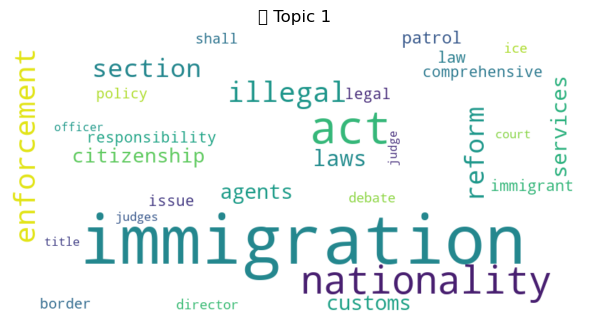

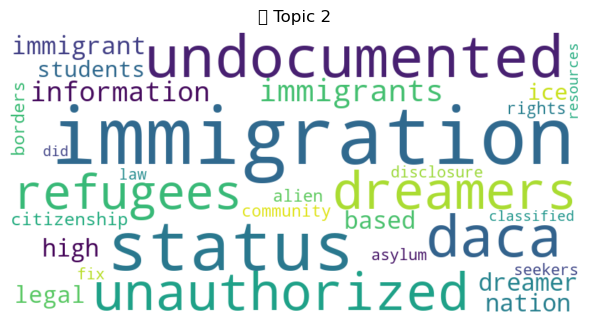

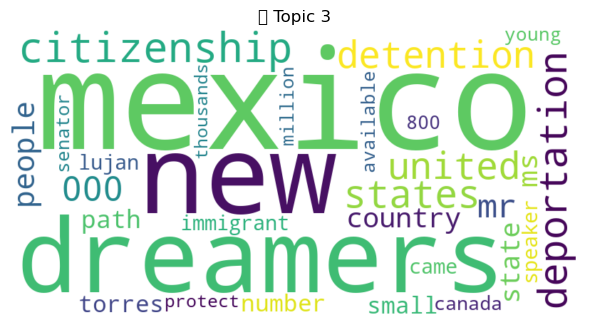

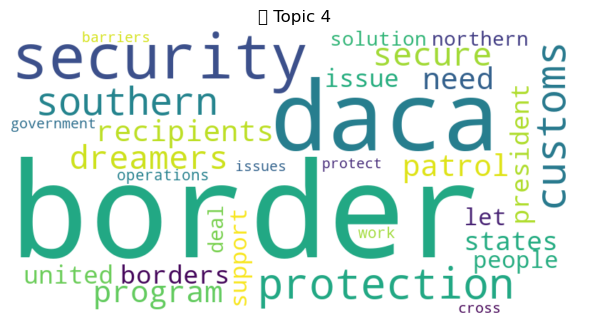

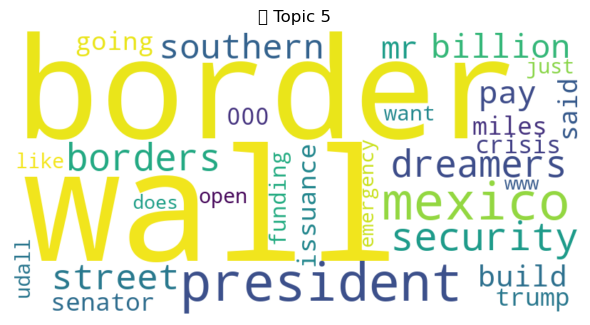

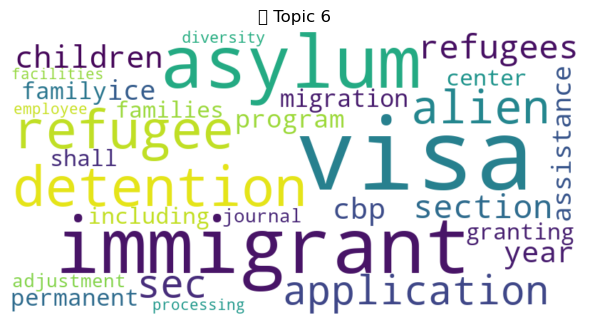

In [38]:

# Visualize each topic with a word cloud
def plot_topic_wordclouds(lda_model, feature_names, n_top_words=30):
    for topic_idx, topic in enumerate(lda_model.components_):
        plt.figure(figsize=(6, 4))
        top_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"🧩 Topic {topic_idx + 1}")
        plt.tight_layout()
        plt.show()

plot_topic_wordclouds(lda, feature_names)


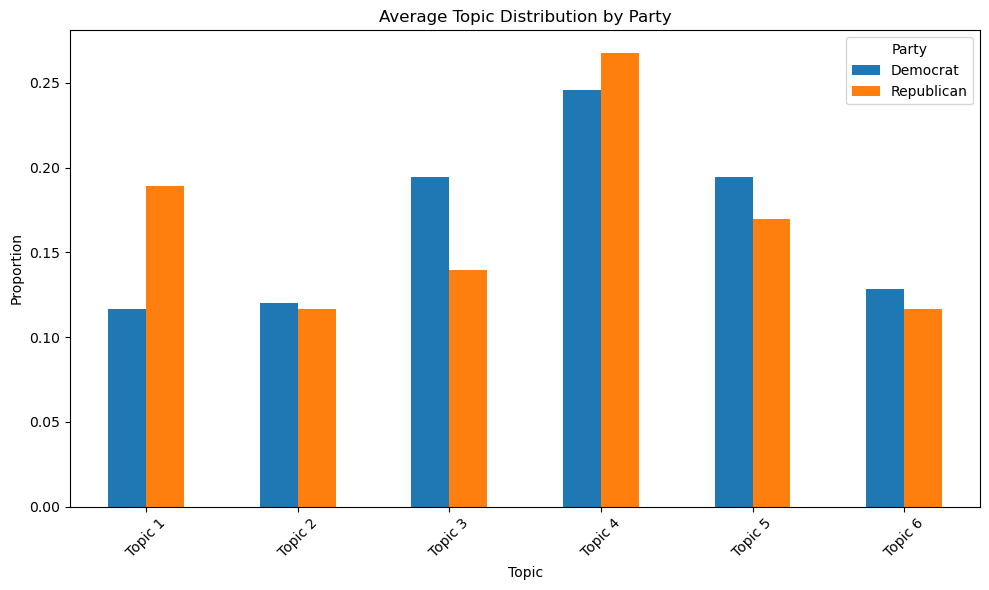

In [39]:

# Ensure topic_distributions and parties are the same length
topic_df = pd.DataFrame(topic_distributions)
topic_df['party'] = parties[:len(topic_df)]  # in case of mismatch

# Only keep rows for Democrat or Republican
topic_df = topic_df[topic_df['party'].isin(['Democrat', 'Republican'])]

# Compute average topic proportions per party
party_topic_avg = topic_df.groupby('party').mean().T

# Plot
party_topic_avg.plot(kind='bar', figsize=(10, 6))
plt.title("Average Topic Distribution by Party")
plt.xlabel("Topic")
plt.ylabel("Proportion")
plt.xticks(ticks=np.arange(len(party_topic_avg)), labels=[f"Topic {i+1}" for i in range(len(party_topic_avg))], rotation=45)
plt.legend(title="Party")
plt.tight_layout()
plt.show()


RQ3 Summary: Contextual Linguistic Patterns Around Immigration

We examined collocates, sentiment, and topic distributions by party to uncover ideological framing in immigration discourse.

- **TF-IDF Collocates:**
  - Democrats: “dreamers,” “refugees,” “program”
  - Republicans: “act,” “enforcement,” “protection”

- **Sentiment Analysis:**
  - Mostly neutral for both parties
  - Republicans had slightly more positive tone on average

- **Topic Modeling (LDA, 6 Topics):**
  - **Topic 1 (Legal Enforcement):** Republican-dominant
  - **Topic 2 (DACA/Undocumented):** Balanced
  - **Topic 3 (Deportation/Citizenship):** Democrat-leaning
  - **Topic 4 (Border Security):** Republican-dominant
  - **Topic 5 (Trump-Era Wall Policy):** Democrat-leaning (likely critical)
  - **Topic 6 (Asylum & Humanitarian Entry):** Democrat-leaning

These patterns reflect consistent ideological divides — Republicans stress security and enforcement, while Democrats emphasize protection, pathways, and critique of harsh immigration policy.


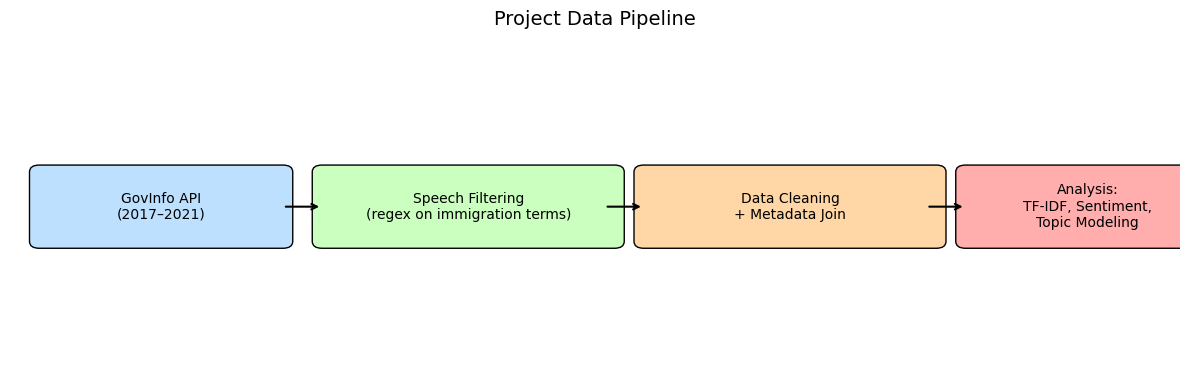

In [35]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xlim(0, 12)
ax.set_ylim(0, 5)
ax.axis('off')

# Draw helper
def draw_step(x, width, label, color):
    box = patches.FancyBboxPatch((x, 2), width, 1, boxstyle="round,pad=0.1", edgecolor="black", facecolor=color)
    ax.add_patch(box)
    ax.text(x + width / 2, 2.5, label, ha='center', va='center', fontsize=10)

# Draw boxes with updated widths and labels
draw_step(0.3, 2.5, "GovInfo API\n(2017–2021)", "#bde0fe")
draw_step(3.2, 3.0, "Speech Filtering\n(regex on immigration terms)", "#caffbf")
draw_step(6.5, 3.0, "Data Cleaning\n+ Metadata Join", "#ffd6a5")
draw_step(9.8, 2.5, "Analysis:\nTF-IDF, Sentiment,\nTopic Modeling", "#ffadad")

# Draw arrows
for x in [2.8, 6.1, 9.4]:
    ax.annotate('', xy=(x + 0.4, 2.5), xytext=(x, 2.5), arrowprops=dict(arrowstyle="->", lw=1.5))

plt.title("Project Data Pipeline", fontsize=14)
plt.tight_layout()
plt.show()
